In [1]:
from __future__ import division
from IPython.display import clear_output
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
import random

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16),
        np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))



In [2]:
# import to do training
from tpg.trainer import Trainer
# import to run an agent (always needed)
from tpg.agent import Agent

from tpg.configurations import DefaultConfiguration

In [3]:
env = gym.make('LunarLander-v2', render_mode='rgb_array') # make the environment

print(env.action_space) # learn size of action space

Discrete(4)


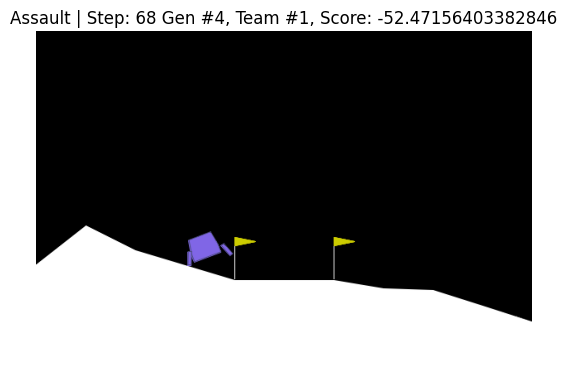

(0, None)
Time Taken (Hours): 0.08898113621605767
Results:
Min, Max, Avg
-703.7455944764954 -94.09151279517718 -433.101511061565
-1879.901236385139 -105.27164756236317 -552.2586564691475
-568.1292128018534 -113.4080695992688 -250.18402443912623
-535.4349736133784 -83.21151805232236 -198.0671041748659
-723.5457355229835 -98.70973448459847 -241.00564133020526


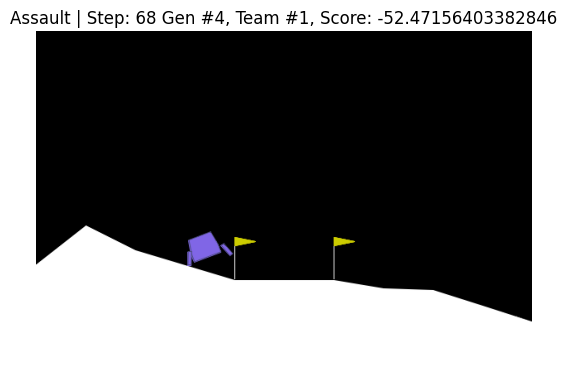

In [4]:
## %matplotlib inline
import time # for tracking time

tStart = time.time()

customConfiguration = DefaultConfiguration()
customConfiguration.teamPopSize = 10

# first create an instance of the TpgTrainer
# this creates the whole population and everything
# teamPopSize should realistically be at-least 100
trainer = Trainer(actions=range(4), config=customConfiguration) 

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores = [] # new list per gen
    
    agents = trainer.getAgents()
    
    while True: # loop to go through agents
        teamNum = len(agents)
        agent = agents.pop()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        state = env.reset()[0] # get initial state and prep environment
        score = 0
        for i in range(500): # run episodes that last 500 frames
            show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)) # render env
            
            # must transform to at-least int-32 (for my getState to bitshift correctly)
            # print(state)
            #print(state)
             
            act = agent.act(state) 

            # feedback from env
            #print("act", act[0])
            print(act)

            state, reward, isTerminated, isTruncated, debug = env.step(act[0])
            
            score += reward # accumulate reward in score
            if isTerminated or isTruncated:
                break # end early if losing state

        agent.reward(score) # must reward agent (if didn't already score)
            
        curScores.append(score) # store score
        
        if len(agents) == 0:
            break
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
#clear_output(wait=True)
print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])